In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet.forecaster import Prophet

# Prophet

In [2]:
from prophet.forecaster import Prophet

In [3]:
df=pd.read_csv("/Users/daniel/Downloads/final_data.csv",sep=";",dtype = {'Libelle': str},parse_dates=['Date et heure de comptage'])
df.drop("Unnamed: 0",axis=1,inplace=True)
df.columns=[name.lower().replace(' ','_') for name in df.columns]
df_stp = df[df["libelle"]=="Sts_Peres"].drop("libelle",axis=1)
df_stp.head()

,date_et_heure_de_comptage,débit_horaire,taux_d'occupation,etat_trafic,etat_arc_barré,etat_arc_invalide,jour_férié,jour_de_la_semaine_0,jour_de_la_semaine_1,jour_de_la_semaine_2,...,cloudcover,heatindexc,dewpointc,windchillc,windgustkmph,feelslikec,is_day,paris_repsire,perturbation_travaux,prix_du_carburant
18384,2022-01-02 23:00:00,260.0,3.10555,1,0,1,0,0,0,0,...,98,12,9,10,33,10,False,False,1.0,1.691
18385,2022-01-02 13:00:00,422.0,5.34889,1,0,1,0,0,0,0,...,88,13,10,11,29,11,True,True,1.0,1.691
18386,2022-01-02 21:00:00,429.0,4.87667,1,0,1,0,0,0,0,...,94,12,9,10,29,10,False,False,1.0,1.691
18387,2022-01-03 00:00:00,250.0,2.87611,1,0,1,0,1,0,0,...,100,12,9,10,36,10,False,False,1.0,1.691
18388,2022-01-02 18:00:00,697.0,9.25667,1,0,1,0,0,0,0,...,71,13,9,11,29,11,False,False,1.0,1.691


In [4]:
start="2022-11-01 00:00:00"
end="2022-12-01 00:00:00"

In [5]:
prophet_model = Prophet(seasonality_mode="additive")

In [6]:
#preparation
df=df_stp.drop("taux_d'occupation", axis=1)

df.rename({"date_et_heure_de_comptage": "ds", "débit_horaire": "y"}, axis=1, inplace=True)

df_train = df.loc[df.ds<start]
df_test = df.loc[(df.ds>=start) & (df.ds<=end)]

In [7]:
#add features
for col in df_train.columns:
    if (col not in ["ds", "y"]):
        prophet_model.add_regressor(col,standardize = "auto")

#fit
prophet_model.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -234.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16916.4    0.00266428       2398.37           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17041.5    0.00391025       1951.09           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17099.3    0.00030776       455.949           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17129.4    0.00138744       797.122           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17143.8       0.01814       577.954           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha   

  17155.9    0.00587789       898.418      0.3373           1      654   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       17165.5   0.000646439       202.094           1           1      767   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       17175.5    0.00152596       465.361           1           1      876   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       17184.7     0.0327941       1363.86        2.95       0.295      982   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       17190.9    0.00037969       319.901           1           1     1091   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       17194.3   0.000161567       252.267      0.6751      0.6751     1202   
    Iter      log prob        |

In [8]:
#Prediction
data_to_pred = df_test.drop("y", axis=1)
y_pred =prophet_model.predict(data_to_pred)

y_pred = y_pred[["ds", "yhat"]]
y_pred.rename({"yhat": "débit_horaire"}, axis=1,inplace=True)

y_pred.set_index("ds", inplace=True)
df_test.set_index("ds", inplace=True)


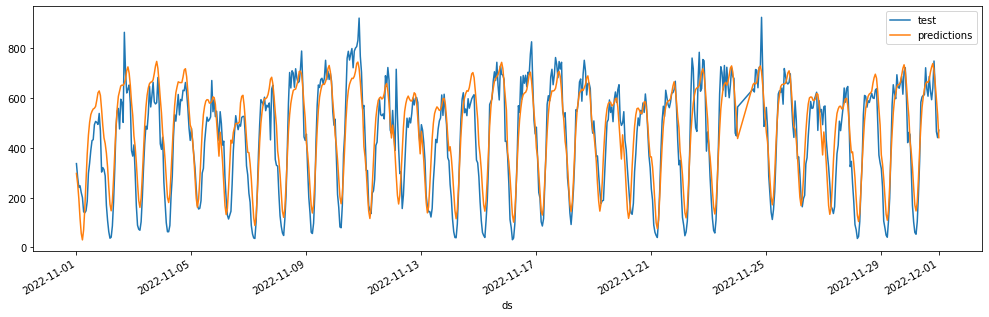

In [9]:
fig, ax = plt.subplots(figsize=(17, 5))
#df_train.iloc[-steps:].y.plot(ax=ax, label='train')
df_test.y.plot(ax=ax, label='test')
y_pred.débit_horaire.plot(ax=ax, label='predictions')
ax.legend();

In [10]:
se = np.square(y_pred.débit_horaire - df_test.y)
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

98.12490524128617

# With Split

In [48]:
data=pd.read_csv("/Users/daniel/Downloads/final_data.csv",sep=";",dtype = {'Libelle': str},parse_dates=['Date et heure de comptage'])
data.drop("Unnamed: 0",axis=1,inplace=True)
data.columns=[name.lower().replace(' ','_') for name in data.columns]
df_stp= data[data["libelle"]=="Sts_Peres"].drop("libelle",axis=1)
df_stp.head()

,date_et_heure_de_comptage,débit_horaire,taux_d'occupation,etat_trafic,etat_arc_barré,etat_arc_invalide,jour_férié,jour_de_la_semaine_0,jour_de_la_semaine_1,jour_de_la_semaine_2,...,cloudcover,heatindexc,dewpointc,windchillc,windgustkmph,feelslikec,is_day,paris_repsire,perturbation_travaux,prix_du_carburant
18384,2022-01-02 23:00:00,260.0,3.10555,1,0,1,0,0,0,0,...,98,12,9,10,33,10,False,False,1.0,1.691
18385,2022-01-02 13:00:00,422.0,5.34889,1,0,1,0,0,0,0,...,88,13,10,11,29,11,True,True,1.0,1.691
18386,2022-01-02 21:00:00,429.0,4.87667,1,0,1,0,0,0,0,...,94,12,9,10,29,10,False,False,1.0,1.691
18387,2022-01-03 00:00:00,250.0,2.87611,1,0,1,0,1,0,0,...,100,12,9,10,36,10,False,False,1.0,1.691
18388,2022-01-02 18:00:00,697.0,9.25667,1,0,1,0,0,0,0,...,71,13,9,11,29,11,False,False,1.0,1.691


In [49]:
prophet_model = Prophet(seasonality_mode="additive")

In [50]:
#prepare
df=df_stp.drop("taux_d'occupation", axis=1)

df.rename({"date_et_heure_de_comptage": "ds", "débit_horaire": "y"}, axis=1, inplace=True)

#reserve 30% of data for testing

#modif de timeseries_train_test_split(df, test_size=0.3)

df.sort_values(by='ds', inplace=True)

test_index = int(len(df)*(1-0.3))

df_train = df.iloc[:test_index]
df_test = df.iloc[test_index:]

df_test.reset_index(drop=True,inplace=True)
df_train.reset_index(drop=True,inplace=True)



/var/folders/jx/28l9xggd2379trg_rfjvhlx80000gn/T/ipykernel_94383/4156026653.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


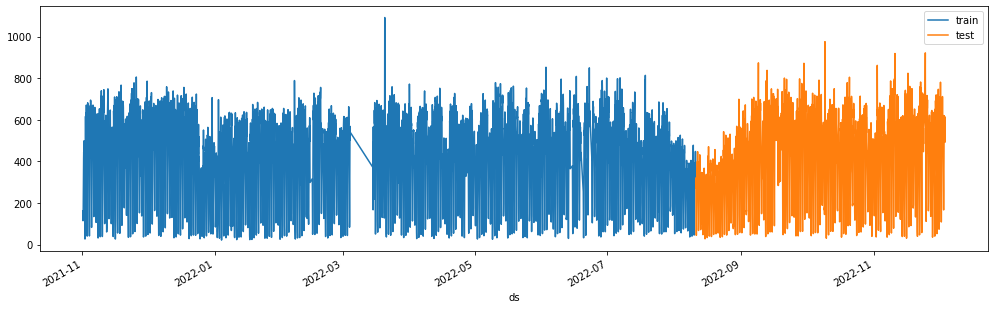

In [51]:
fig, ax = plt.subplots(figsize=(17, 5))
df_train.set_index("ds").y.plot(ax=ax, label='train')
df_test.set_index("ds").y.plot(ax=ax, label='test')
ax.legend();
fig.show()

In [52]:
#add features
for col in df_train.columns:
    if (col not in ["ds", "y"]):
        prophet_model.add_regressor(col,standardize = "auto")
        
#fit
prophet_model.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -180.442


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13403.9    0.00280515       1660.87           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       13441.3     0.0132902       950.558           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13466.9    0.00278179       1021.88           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       13477.9   0.000683265       450.228      0.4065           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       13483.4   0.000714782       521.286      0.3615           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [53]:
#Prediction
data_to_pred = df_test.drop("y", axis=1)
y_pred =prophet_model.predict(data_to_pred)

y_pred = y_pred[["ds", "yhat"]]
y_pred.rename({"yhat": "débit_horaire"}, axis=1,inplace=True)

y_pred.set_index("ds", inplace=True)
df_test.set_index("ds", inplace=True)

  13489.9    0.00324687       296.673           1           1      664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       13492.2    0.00186674       272.749           1           1      772   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       13493.2   0.000374051       545.285       0.722       0.722      882   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       13494.3   0.000399808       126.112      0.3208           1      990   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999         13495    0.00135769       174.043           1           1     1097   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099         13496    0.00163564        141.24      0.8355      0.8355     1206   
    Iter      log prob        |

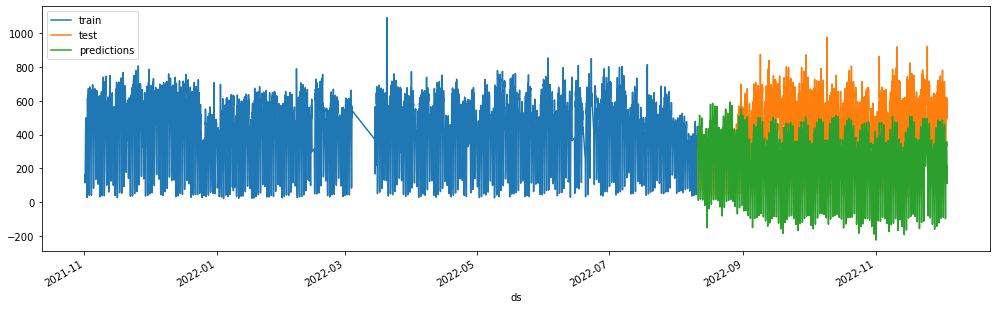

In [54]:
fig, ax = plt.subplots(figsize=(17, 5))
df_train.set_index("ds").y.plot(ax=ax, label='train')
df_test.y.plot(ax=ax, label='test')
y_pred.débit_horaire.plot(ax=ax, label='predictions')
ax.legend();

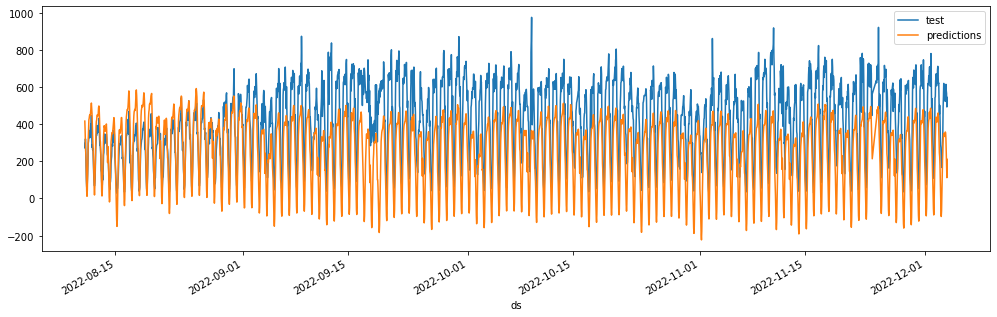

In [55]:
fig, ax = plt.subplots(figsize=(17, 5))
df_test.y.plot(ax=ax, label='test')
y_pred.débit_horaire.plot(ax=ax, label='predictions')
ax.legend();

In [56]:
se = np.square(y_pred.débit_horaire - df_test.y)
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

210.81231428103823

Valeur absolue pour les valeurs négatives

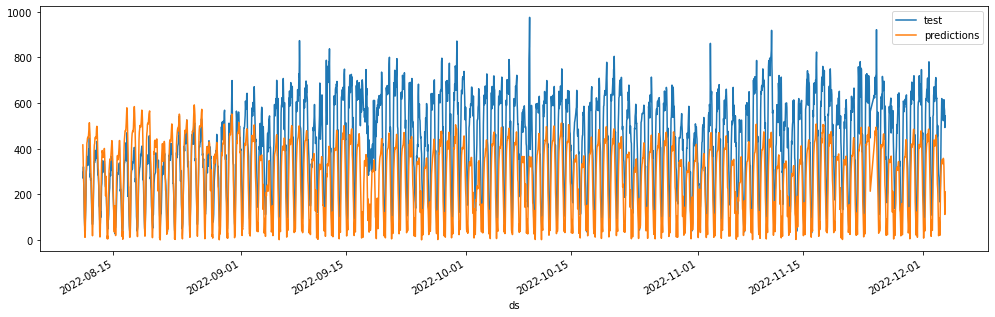

In [57]:
fig, ax = plt.subplots(figsize=(17, 5))
df_test.y.plot(ax=ax, label='test')
y_pred.abs().débit_horaire.plot(ax=ax, label='predictions')
ax.legend();

In [58]:
se = np.square(y_pred.abs().débit_horaire - df_test.y)
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

197.17487864701198

Remplacement par valeur minimum pour les valeurs négatives

In [59]:
min_value=df.set_index("ds").y.min()
min_value

22.0

In [60]:
#penser à enlever le négatif ! soit remplacer par 0 soit valeur mini de la target sur l'ensemble du dataset
#y_pred.loc[y_pred["débit_horaire"]<0, "débit_horaire"] = 0
y_pred.loc[y_pred["débit_horaire"]<min_value, "débit_horaire"] = min_value

se = np.square(y_pred.débit_horaire - df_test.y)
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

199.39380930094094

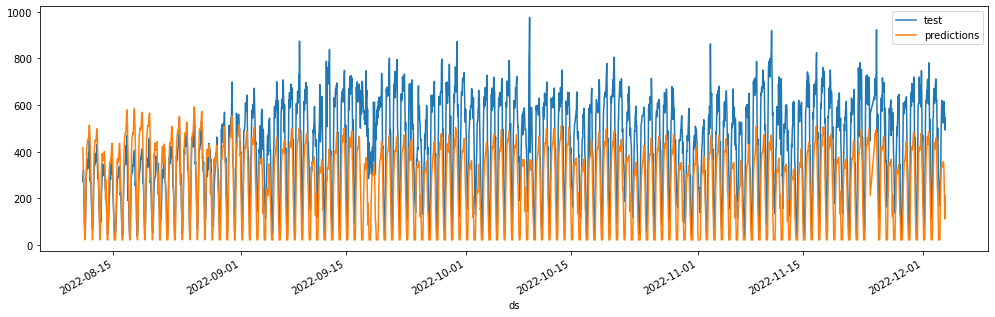

In [61]:
fig, ax = plt.subplots(figsize=(17, 5))
df_test.y.plot(ax=ax, label='test')
y_pred.débit_horaire.plot(ax=ax, label='predictions')

ax.legend();


# Généralisation 

In [23]:
data=pd.read_csv("/Users/daniel/Downloads/final_data.csv",sep=";",dtype = {'Libelle': str},parse_dates=['Date et heure de comptage'])
data.drop("Unnamed: 0",axis=1,inplace=True)
data.columns=[name.lower().replace(' ','_') for name in data.columns]
data.head()

,libelle,date_et_heure_de_comptage,débit_horaire,taux_d'occupation,etat_trafic,etat_arc_barré,etat_arc_invalide,jour_férié,jour_de_la_semaine_0,jour_de_la_semaine_1,...,cloudcover,heatindexc,dewpointc,windchillc,windgustkmph,feelslikec,is_day,paris_repsire,perturbation_travaux,prix_du_carburant
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,1,0,1,1,0,0,...,4,12,8,11,16,11,True,False,0.0,1.691
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,1,0,1,1,0,0,...,9,9,8,8,16,8,False,False,0.0,1.691
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,3,0,1,1,0,0,...,19,11,7,11,16,11,False,False,0.0,1.691
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,3,0,1,1,0,0,...,21,12,7,11,15,11,False,False,0.0,1.691
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,1,0,1,1,0,0,...,7,9,8,8,18,8,True,False,0.0,1.691


In [24]:
start="2022-11-01 00:00:00"
end="2022-12-01 00:00:00"
results=pd.DataFrame(columns=["arc","target","rmse","y_pred_clean"])

Initial log joint probability = -167.733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17468.6   0.000589536       469.668       2.785      0.2785      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17470.3   0.000540883       254.624      0.9321      0.9321      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17471.6   0.000220784       196.648           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17472.7   0.000690274       307.531           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17473.1   8.57325e-06       77.5942      0.4568      0.4568      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


Initial log joint probability = -134.276
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16251.8   0.000347562       437.742      0.6693      0.6693      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         16258    0.00136651       358.072           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16259.4   0.000146909       253.881           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       16259.4   0.000116093       177.669   1.039e-06       0.001      423  LS failed, Hessian reset 
     374       16259.5   7.06712e-07        103.06      0.5611      0.5611      473   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -53.1324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22618.8   0.000415472       494.666           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22619.3   0.000125984       113.919           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22619.4   0.000100715       125.662           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       22619.5   2.33882e-06       70.3974      0.2663      0.2663      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       22619.5   1.56165e-06       96.4696      0.3063           1      504   
Optimization terminated normally: 
  Convergence detected: relat

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -444.502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15680.6    0.00176471       366.605           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15685.1    0.00387661       482.353           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15686.7    0.00444053       356.093           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15687.4   0.000253181       101.434           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15688.4   5.54828e-05       116.567           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -34.6767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23675.6   0.000924655       853.543           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23678.1   0.000121915       242.859      0.8643      0.8643      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23678.5   0.000400976       128.849           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23678.6   2.57723e-06       85.4632           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       23678.7   1.35584e-05       183.931   1.489e-07       0.001      532  LS failed, Hessian reset 
     499       23678.7   4.16827e-06    

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -234.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17746.5   0.000432436       320.102           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17748.8   0.000946846       193.719           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17749.6   9.03898e-05       153.319      0.6811      0.6811      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         17750   0.000899795        264.18           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17750.6   0.000295447       135.395           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


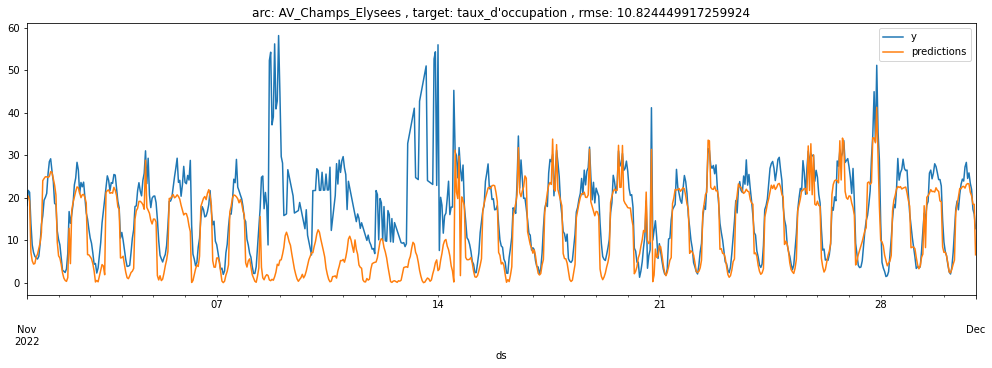

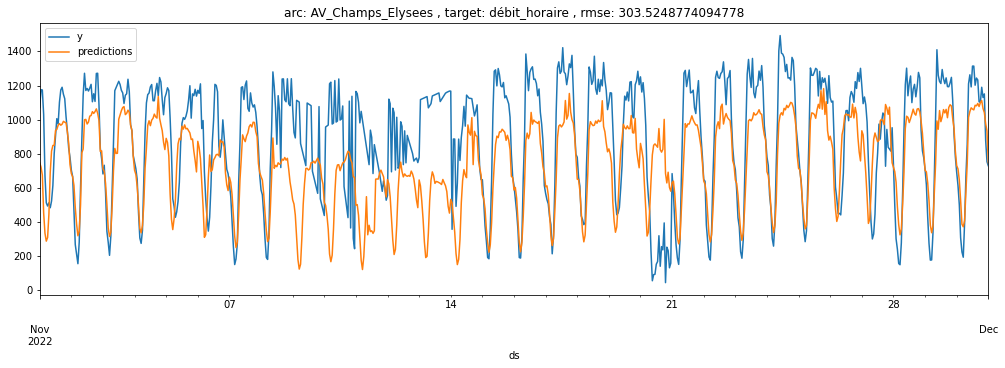

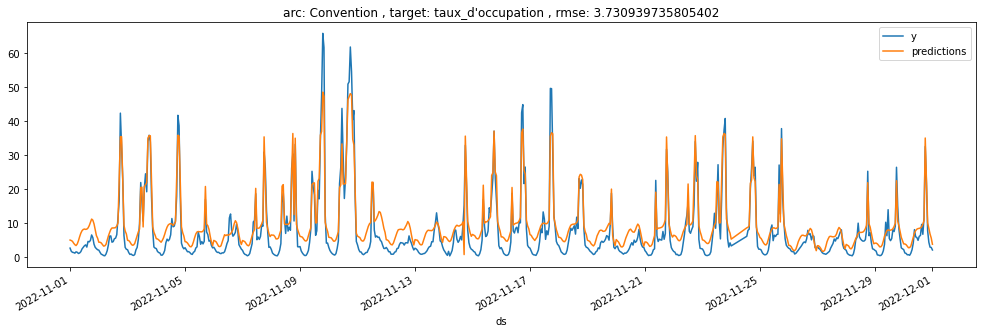

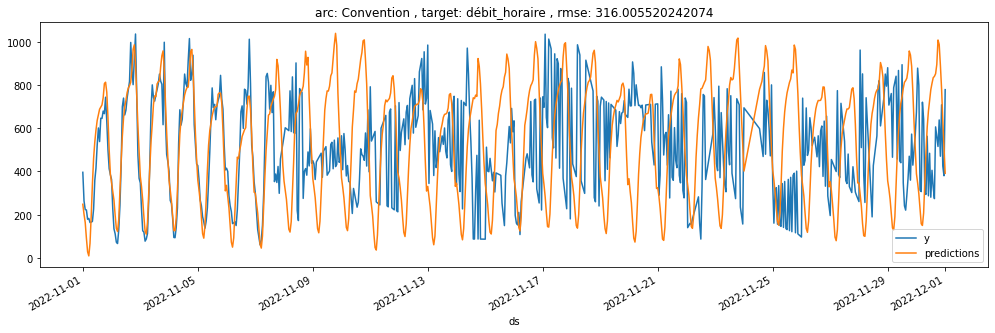

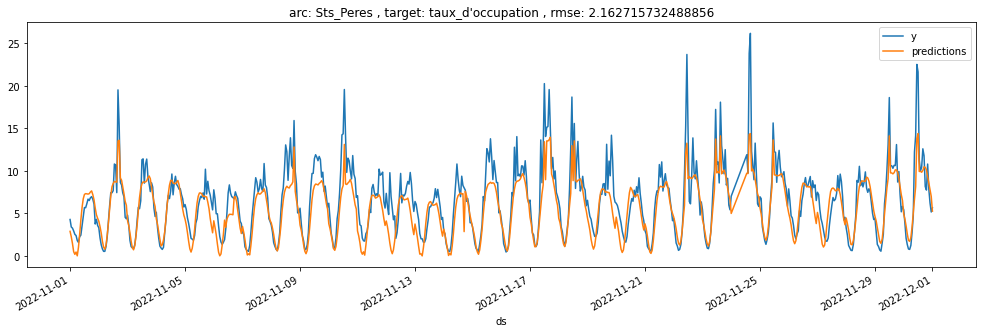

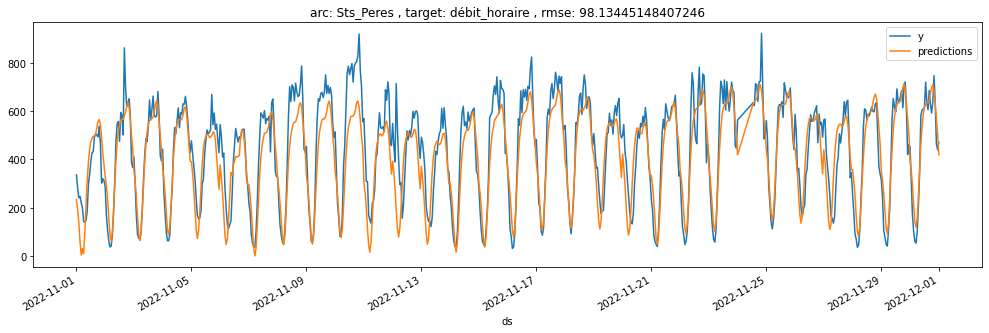

In [25]:
for arc in list(data.libelle.unique()):
    
    df_arc = data[data["libelle"]==arc].drop("libelle",axis=1)

    for target in ["taux_d'occupation","débit_horaire"]:
        
        #df preparation train/test
        if(target=="taux_d'occupation"):
            df_target=df_arc.drop("débit_horaire", axis=1)
            
        if(target=="débit_horaire"):
            df_target=df_arc.drop("taux_d'occupation", axis=1)

        df_target.rename({"date_et_heure_de_comptage": "ds", target: "y"}, axis=1, inplace=True)
        
        df_target.sort_values(by='ds', inplace=True)

        df_train = df_target.loc[df_target.ds<start]
        
        df_test = df_target.loc[(df_target.ds>=start) & (df_target.ds<=end)]
        
        #model definition
        prophet_model = Prophet(seasonality_mode="additive",yearly_seasonality=True)
        
        #add features
        for col in df_train.columns:
            if (col not in ["ds", "y"]):
                prophet_model.add_regressor(col,standardize = "auto")

        #fit
        prophet_model.fit(df_train)

        #Prediction
        X_test = df_test.drop("y", axis=1)
        y_test= df_test[["ds", "y"]]
        
        y_pred = prophet_model.predict(X_test)

        y_pred_clean = y_pred[["ds", "yhat"]]
        y_pred_clean.rename({"yhat": target}, axis=1,inplace=True)
        
        y_pred_clean.set_index("ds", inplace=True)
        y_test.set_index("ds", inplace=True)

        #erreurs
        #min_value=df_target.set_index("ds").y.min()
        #y_pred_clean.loc[y_pred_clean[target]<min_value, target] = min_value
        y_pred_clean =y_pred_clean.abs()
        
        #rmse
        se = np.square(y_pred_clean[target] - y_test.y)
        mse = np.mean(se)
        rmse = np.sqrt(mse)
        
        #visualisation
        titre="arc: "+arc+" , target: "+target+" , rmse: "+str(rmse)
        fig, ax = plt.subplots(figsize=(17, 5))
        y_test.plot(ax=ax, label='test')
        y_pred_clean[target].plot(ax=ax, label='predictions')
        ax.set_title(titre)
        ax.legend();
        
        line=[arc,target,rmse,y_pred_clean]
        results.loc[len(results)] = line


In [26]:
results

,arc,target,rmse,y_pred_clean
0,AV_Champs_Elysees,taux_d'occupation,10.824450,taux_d'occupation ds ...
1,AV_Champs_Elysees,débit_horaire,303.524877,débit_horaire ds ...
2,Convention,taux_d'occupation,3.730940,taux_d'occupation ds ...
3,Convention,débit_horaire,316.005520,débit_horaire ds ...
4,Sts_Peres,taux_d'occupation,2.162716,taux_d'occupation ds ...
5,Sts_Peres,débit_horaire,98.134451,débit_horaire ds ...


# Challenge

In [27]:
output=pd.DataFrame(columns=["arc","datetime","debit_horaire","taux_occupation"])
start="2022-11-01 00:00:00"
end="2022-12-01 00:00:00"

In [28]:
data=pd.read_csv("/Users/daniel/Downloads/final_data.csv",sep=";",dtype = {'Libelle': str},parse_dates=['Date et heure de comptage'])
data.drop("Unnamed: 0",axis=1,inplace=True)
data.columns=[name.lower().replace(' ','_') for name in data.columns]

df_concat_arc=pd.DataFrame()

for arc in list(data.libelle.unique()):
    
    df_arc = data[data["libelle"]==arc].drop("libelle",axis=1)
    
    df_merge_target=pd.DataFrame(columns=["arc"],index=pd.date_range(start=start, end=end, freq='H'))
    
    for target in ["débit_horaire","taux_d'occupation"]:
        
        #df preparation train/test
        if(target=="taux_d'occupation"):
            df_target=df_arc.drop("débit_horaire", axis=1)
            
        if(target=="débit_horaire"):
            df_target=df_arc.drop("taux_d'occupation", axis=1)

        df_target.rename({"date_et_heure_de_comptage": "ds", target: "y"}, axis=1, inplace=True)
        
        df_target.sort_values(by='ds', inplace=True)

        df_train = df_target.loc[df_target.ds<start]
        
        df_test = df_target.loc[(df_target.ds>=start) & (df_target.ds<=end)]
        
        #model definition
        prophet_model = Prophet(seasonality_mode="additive",yearly_seasonality=True)
        
        #add features
        for col in df_train.columns:
            if (col not in ["ds", "y"]):
                prophet_model.add_regressor(col,standardize = "auto")

        #fit
        prophet_model.fit(df_train)

        #Prediction
        X_test = df_test.drop("y", axis=1)
        y_test= df_test[["ds", "y"]]
        
        y_pred = prophet_model.predict(X_test)

        y_pred_clean = y_pred[["ds", "yhat"]]
        y_pred_clean.rename({"yhat": target}, axis=1,inplace=True)
        
        y_pred_clean.set_index("ds", inplace=True)
        y_test.set_index("ds", inplace=True)

        #erreurs
        #min_value=df_target.set_index("ds").y.min()
        #y_pred_clean.loc[y_pred_clean[target]<min_value, target] = min_value
        y_pred_clean = y_pred_clean.abs()   
        
        df_merge_target=pd.merge(df_merge_target,y_pred_clean, how='inner', left_index=True, right_index=True)
    
    df_merge_target["arc"]=arc
    df_concat_arc=pd.concat([df_concat_arc, df_merge_target])
    

Initial log joint probability = -134.276
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16251.8   0.000347562       437.742      0.6693      0.6693      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         16258    0.00136651       358.072           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16259.4   0.000146909       253.881           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       16259.4   0.000116093       177.669   1.039e-06       0.001      423  LS failed, Hessian reset 
     374       16259.5   7.06712e-07        103.06      0.5611      0.5611      473   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -167.733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17468.6   0.000589536       469.668       2.785      0.2785      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17470.3   0.000540883       254.624      0.9321      0.9321      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17471.6   0.000220784       196.648           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17472.7   0.000690274       307.531           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17473.1   8.57325e-06       77.5942      0.4568      0.4568      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -444.502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15680.6    0.00176471       366.605           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15685.1    0.00387661       482.353           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15686.7    0.00444053       356.093           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15687.4   0.000253181       101.434           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15688.4   5.54828e-05       116.567           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -53.1324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22618.8   0.000415472       494.666           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22619.3   0.000125984       113.919           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22619.4   0.000100715       125.662           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       22619.5   2.33882e-06       70.3974      0.2663      0.2663      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       22619.5   1.56165e-06       96.4696      0.3063           1      504   
Optimization terminated normally: 
  Convergence detected: relat

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -234.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17746.5   0.000432436       320.102           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17748.8   0.000946846       193.719           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17749.6   9.03898e-05       153.319      0.6811      0.6811      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         17750   0.000899795        264.18           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17750.6   0.000295447       135.395           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -34.6767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23675.6   0.000924655       853.543           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23678.1   0.000121915       242.859      0.8643      0.8643      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23678.5   0.000400976       128.849           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23678.6   2.57723e-06       85.4632           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       23678.7   1.35584e-05       183.931   1.489e-07       0.001      532  LS failed, Hessian reset 
     499       23678.7   4.16827e-06    

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [29]:
temp=df_concat_arc.copy()

In [30]:
temp.reset_index(inplace=True)
temp['index']=temp['index'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
temp.rename(columns={"index":"datetime","débit_horaire":"debit_horaire","taux_d'occupation":"taux_occupation"},inplace=True)
temp.replace({"arc": {"AV_Champs_Elysees":"Champs-Elysées", "Convention":"Convention","Sts_Peres":"Saint-Pères"}},inplace=True)

In [31]:
output=temp[["arc","datetime","taux_occupation","debit_horaire"]]

In [32]:
output

,arc,datetime,taux_occupation,debit_horaire
0,Champs-Elysées,2022-11-01 00:00,20.190481,747.186892
1,Champs-Elysées,2022-11-01 01:00,20.411279,722.128660
2,Champs-Elysées,2022-11-01 02:00,19.245870,675.876324
3,Champs-Elysées,2022-11-01 03:00,7.150836,453.509360
4,Champs-Elysées,2022-11-01 04:00,5.131775,334.562504
...,...,...,...,...
2134,Saint-Pères,2022-11-30 20:00,9.327584,682.563020
2135,Saint-Pères,2022-11-30 21:00,8.481965,630.418709
2136,Saint-Pères,2022-11-30 22:00,7.694269,565.559314
2137,Saint-Pères,2022-11-30 23:00,7.009412,505.690076


In [33]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   arc              2139 non-null   object 
 1   datetime         2139 non-null   object 
 2   taux_occupation  2139 non-null   float64
 3   debit_horaire    2139 non-null   float64
dtypes: float64(2), object(2)
memory usage: 67.0+ KB
